In [33]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils
from sklearn.preprocessing import MinMaxScaler

In [34]:
from lstpnet_util import *
model = LSTPNet(args)

In [35]:
idxs = get_train_val_test_idxs(args)
train_dataset = LstpDataset(args,transforms.Compose([Normalize(args),ToTensor()]),idxs['train'])
val_dataset = LstpDataset(args,transforms.Compose([Normalize(args),ToTensor()]),idxs['val'])
test_dataset = LstpDataset(args,transforms.Compose([Normalize(args),ToTensor()]),idxs['test'])

train_dataloader = DataLoader(train_dataset,batch_size=args.batch_size,shuffle=True,num_workers=4)
val_dataloader = DataLoader(val_dataset,batch_size=args.batch_size,shuffle=True,num_workers=4)
test_dataloader = DataLoader(test_dataset,batch_size=args.batch_size,shuffle=False,num_workers=4)

In [36]:
for i, batch_data in enumerate(train_dataloader):
    print(batch_data['x'].shape)
    break

torch.Size([512, 168, 5])


In [38]:
# device = torch.device('cuda') if args.use_gpu is True else torch.device('cpu')
def train(epochs, n_batch_show_loss=10):
    lstpnet = LSTPNet(args)
#     lstpnet = Model(args)
    optimizer = torch.optim.Adam(lstpnet.parameters())
#     criterion = nn.MSELoss(reduction='mean')
#     criterion = nn.L1Loss(reduction='mean')
    criterion = MyLoss(l1_weight=2,l2_weight=0.01,reduction='mean')
    n_batchs_train = None
    n_batchs_test = None
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        running_loss = 0
        for i_batch, sample_batch in enumerate(train_dataloader):
            x,y = sample_batch['x'],sample_batch['y']
            optimizer.zero_grad()
            
            yhat = lstpnet(x)
            loss = criterion(yhat,y)
            loss.backward()
            optimizer.step()
            n_batchs_train = i_batch + 1
            running_loss += loss.data.item()
#             if i_batch % n_batch_show_loss == n_batch_show_loss-1:
#                 print(f'epoch: {epoch}, i_batch: {i_batch+1}, loss: {running_loss / n_batch_show_loss}')
#                 running_loss = 0
    
        val_loss = 0
        for i_batch, sample_batch in enumerate(val_dataloader):
            yhat = lstpnet(x)
            loss = criterion(yhat,y)
            val_loss += loss.data.item()
            n_batchs_test = i_batch+1
        train_loss = running_loss / n_batchs_train
        val_loss = val_loss / n_batchs_test
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'epoch: {epoch}, batches: {(n_batchs_train,n_batchs_test)}, train_loss: {train_loss},loss: {val_loss}')
                
    print('Finished Training')
    torch.save(lstpnet,'save/lstpnet.pkl')
    torch.save(lstpnet.state_dict(),'lstpnet_params.pkl')
    return train_losses, val_losses

In [39]:
train_losses,val_losses = train(100)

epoch: 0, batches: (34, 12), train_loss: 0.38699590809205,loss: 0.23250300313035646
epoch: 1, batches: (34, 12), train_loss: 0.2097250109209734,loss: 0.20106595382094383
epoch: 2, batches: (34, 12), train_loss: 0.1740384009831092,loss: 0.16107021272182465
epoch: 3, batches: (34, 12), train_loss: 0.15219067190499866,loss: 0.11902354968090852
epoch: 4, batches: (34, 12), train_loss: 0.1409478597342968,loss: 0.20057373121380806
epoch: 5, batches: (34, 12), train_loss: 0.12974217030055382,loss: 0.11640348223348458
epoch: 6, batches: (34, 12), train_loss: 0.12174201471840634,loss: 0.09690228539208572
epoch: 7, batches: (34, 12), train_loss: 0.11635676376959857,loss: 0.1188124908755223
epoch: 8, batches: (34, 12), train_loss: 0.11087890144656687,loss: 0.10170986317098141
epoch: 9, batches: (34, 12), train_loss: 0.10842118565650548,loss: 0.1606019139289856
epoch: 10, batches: (34, 12), train_loss: 0.1046140193939209,loss: 0.0962686153749625
epoch: 11, batches: (34, 12), train_loss: 0.10191266

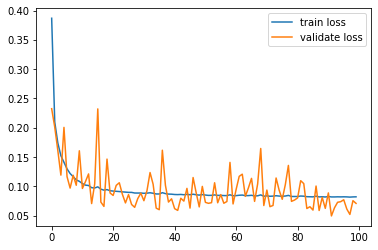

In [40]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(('train loss','validate loss'))

In [41]:
net = torch.load('save/lstpnet.pkl')
test_idxs = idxs['test']
X = []
Y = []

for test_idx in test_idxs:
    x = args.data[test_idx-args.window_size:test_idx]
    scaler = None
    if args.scaler is 'minmax':
        scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    X.append(x)
    y = np.array(args.data[test_idx]).reshape(1,-1)
    y = scaler.transform(y)
    y = y.reshape(-1)
    Y.append(y)
X = np.array(X)
Y = np.array(Y)
print(X.shape,Y.shape)
yhat = net(torch.from_numpy(X))
yhat = yhat.detach().numpy()
print(yhat.shape)

(5667, 168, 5) (5667, 5)
(5667, 5)


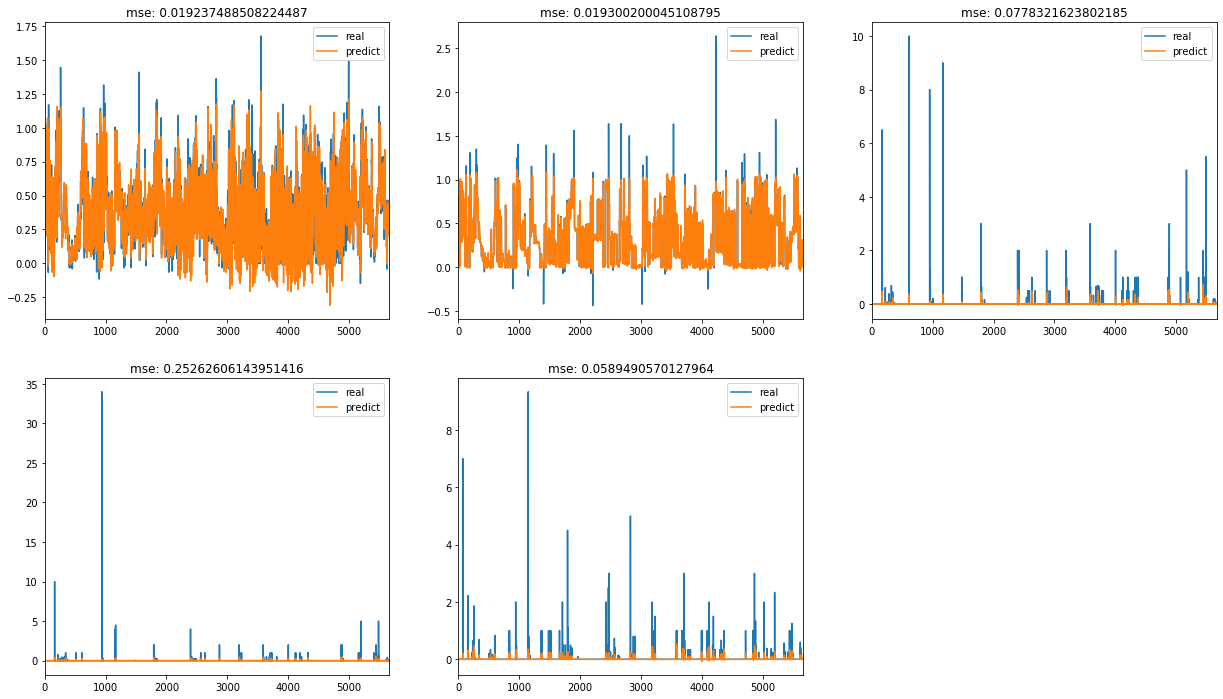

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

plot_col_index = 1
y_df = pd.DataFrame(Y,columns=None)
yhat_df = pd.DataFrame(yhat,columns=None)
num_lines = y_df.shape[1]
plt.figure(figsize=(21,12))
for i in range(num_lines):
    plt.subplot(int(num_lines/3+1),3,i+1)
    y_df[i].plot()
    yhat_df[i].plot()
    mse = mean_squared_error(y_df[i],yhat_df[i])
    plt.title(f'mse: {mse}')
    plt.legend(('real','predict'))
plt.show()

In [101]:
import copy
data = copy.deepcopy(args.data)

In [102]:
Yhat = []
Y = []
for test_idx in test_idxs[300:310]:
    print(test_idx)
    x = data[test_idx-args.window_size:test_idx]
    if args.scaler is 'minmax':
        scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = torch.from_numpy(x).view(1,args.window_size,args.feature_dim)
#     print(x.shape)
    yhat = net(x)
    y = np.array(data[test_idx]).reshape(1,-1)
    y = scaler.transform(y)
    y = y.reshape(-1)
    Y.append(y)
    Yhat.append(yhat.detach().numpy())
    data[test_idx] = scaler.inverse_transform(Yhat[-1])

22965
22966
22967
22968
22969
22970
22971
22972
22973
22974


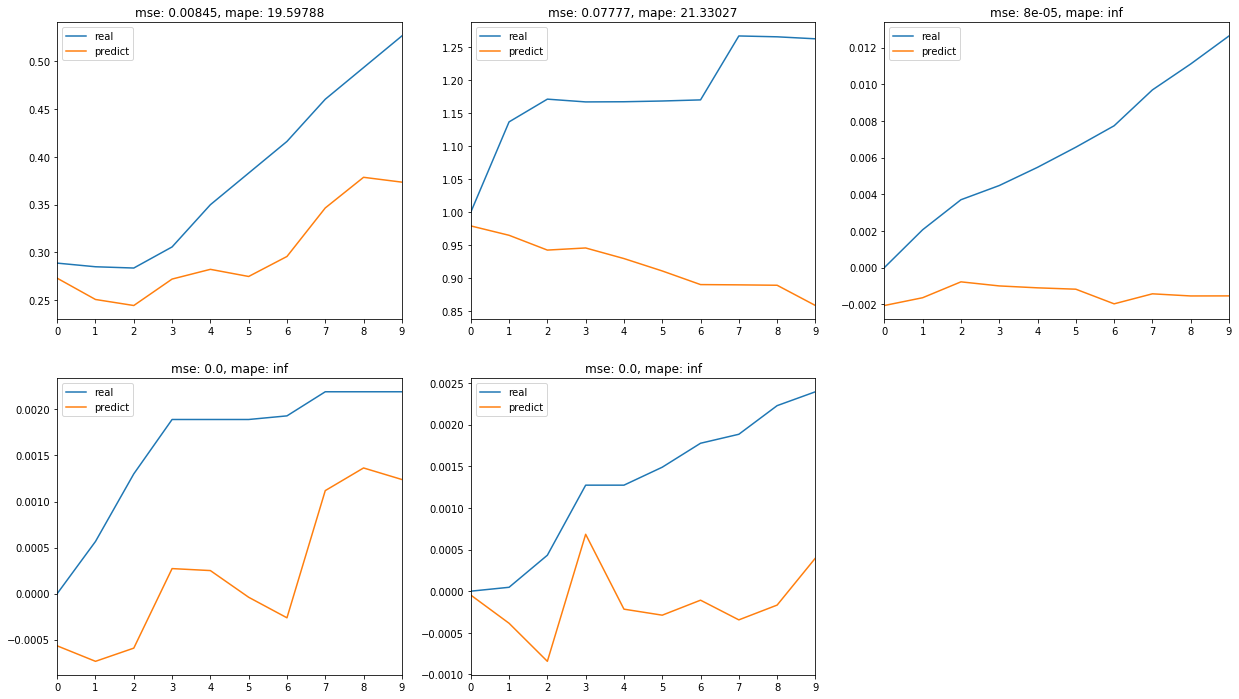

In [103]:
plot_col_index = 1
y_df = pd.DataFrame(Y,columns=None)
yhat_df = pd.DataFrame(np.array(Yhat).reshape(-1,args.feature_dim),columns=None)
num_lines = y_df.shape[1]
plt.figure(figsize=(21,12))
for i in range(num_lines):
    plt.subplot(int(num_lines/3+1),3,i+1)
    y_df[i].plot()
    yhat_df[i].plot()
    mse = mean_squared_error(y_df[i],yhat_df[i])
    _mape = mape(y_df[i],yhat_df[i])
    plt.title(f'mse: {np.round(mse,5)}, mape: {np.round(_mape,5)}')
    plt.legend(('real','predict'))
plt.show()

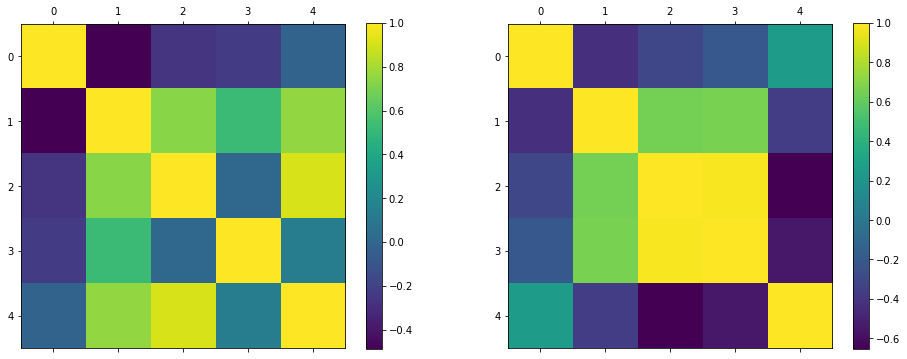

In [48]:
plt.figure(figsize=(16,6))
fig1 = plt.subplot(1,2,1)
cax = fig1.matshow(y_df.corr())
plt.colorbar(cax)
fig2 = plt.subplot(1,2,2)
cax = fig2.matshow(yhat_df.corr())
plt.colorbar(cax)
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, arg):
        super(Model, self).__init__()
#         self.use_cuda = args.cuda
        self.P = args.window_size;
        self.m = args.feature_dim
        self.hidR = args.gru1_hide_dim;
        self.hidC = args.cnn_out_channel;
        self.hidS = args.gru2_hide_dim;
        self.Ck = args.cnn_kernal_size;
        self.skip = args.period_cycle;
        self.pt = int((self.P - self.Ck)/self.skip)
        self.hw = args.formerN_time_stamp
        self.conv1 = nn.Conv2d(1, self.hidC, kernel_size = (self.Ck, self.m));
        self.GRU1 = nn.GRU(self.hidC, self.hidR);
        self.dropout = nn.Dropout(p = args.dropout);
        if (self.skip > 0):
            self.GRUskip = nn.GRU(self.hidC, self.hidS);
            self.linear1 = nn.Linear(self.hidR + self.skip * self.hidS, self.m);
        else:
            self.linear1 = nn.Linear(self.hidR, self.m);
        if (self.hw > 0):
            self.highway = nn.Linear(self.hw, 1);
        self.output = None;
        if (args.output_fun == 'sigmoid'):
            self.output = F.sigmoid;
        if (args.output_fun == 'tanh'):
            self.output = F.tanh;
 
    def forward(self, x):
        batch_size = x.size(0);
        
        #CNN
        c = x.view(-1, 1, self.P, self.m);
        c = F.relu(self.conv1(c));
        c = self.dropout(c);
        c = torch.squeeze(c, 3);
        
        # RNN 
        r = c.permute(2, 0, 1).contiguous();
        _, r = self.GRU1(r);
        r = self.dropout(torch.squeeze(r,0));

        
        #skip-rnn
        
        if (self.skip > 0):
            s = c[:,:, int(-self.pt * self.skip):].contiguous();
            s = s.view(batch_size, self.hidC, self.pt, self.skip);
            s = s.permute(2,0,3,1).contiguous();
            s = s.view(self.pt, batch_size * self.skip, self.hidC);
            _, s = self.GRUskip(s);
            s = s.view(batch_size, self.skip * self.hidS);
            s = self.dropout(s);
            r = torch.cat((r,s),1);
        
        res = self.linear1(r);
        
        #highway
        if (self.hw > 0):
            z = x[:, -self.hw:, :];
            z = z.permute(0,2,1).contiguous().view(-1, self.hw);
            z = self.highway(z);
            z = z.view(-1,self.m);
            res = res + z;
            
        if (self.output):
            res = self.output(res);
        return res;

In [23]:
a = np.load('data/er.npz')['a']
b = np.load('data/reservoir.npz')['a']
a.dtype,b.dtype

(array([0.7855  , 1.611   , 0.861698, 0.634196, 0.211242, 0.006838,
        0.593   , 0.525486], dtype=float32),
 array([180.475,  67.   ,   0.   ,   0.   ,   0.   ], dtype=float32))